<a href="https://colab.research.google.com/github/mannixp/PDF_Equation/blob/main/Diffusion_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1D Diffusion**

This notebook validates the Fokker-Planck like equation derived in the paper Craske J. et al. 2024 by computing each of the relevant terms numerically for the case of 1D scalar diffusion on a bounded domain. To solve this equation we use the open source pseudo-spectral code Dedalus.

**Setup**

This cell checks if Dedalus is installed and performs some other basic setup.


In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install --no-cache http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus already installed :)



**Content**

First let's import everything we need to run the rest of the notebook.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
import h5py
logger = logging.getLogger(__name__)
%matplotlib widget


Next we solve the equation for the scalar concentration
\begin{equation}
\partial_t C = \kappa \partial_z^2 C, \quad z \in [0,1],
\end{equation}
over the time interval $t \in [0,1]$ subject to the Robin boundary conditions
\begin{aligned}
 C - \beta \partial_z C &= g_0(t), \quad \text{at} \quad z = 0, \\
 C + \beta \partial_z C &= g_1(t), \quad \text{at} \quad z = 1,
\end{aligned}
for the initial condition
\begin{equation}
C(z,t=0) = \tanh(10(z-1/2)).
\end{equation}

In [3]:
# Parameters
β = 2
kappa = 0.1

Nz=1024
stop_sim_time = 1
timestep      = 1e-03

zcoord = d3.Coordinate('z')
dist   = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.ChebyshevT(zcoord, size=Nz, bounds=(0,1),dealias=3/2)

# Fields
C      = dist.Field(name='c', bases=zbasis)
tau_c1 = dist.Field(name='tau_c1')
tau_c2 = dist.Field(name='tau_c2')
g0     = dist.Field(name='g0')
g1     = dist.Field(name='g1')

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)
Cz = dz(C)  + lift(tau_c1)
Czz= dz(Cz) + lift(tau_c2)

# Problem
problem = d3.IVP([C, tau_c1, tau_c2], namespace=locals())
problem.add_equation("dt(C) - kappa*Czz = 0")
problem.add_equation("C(z=0) - β*dz(C)(z=0) = g0")
problem.add_equation("C(z=1) + β*dz(C)(z=1) = g1")

# Solver
solver = problem.build_solver(d3.RK222)
solver.stop_sim_time = stop_sim_time

# Initial condition
z      = dist.local_grid(zbasis)
C['g'] = np.tanh(10*(z-.5))

# Flow properties
flow = d3.GlobalFlowProperty(solver, cadence=100)
flow.add_property(d3.Integrate(C**2) , name='<C^2>')
flow.add_property(d3.Integrate(Cz**2), name='<Cz^2>')

B_video = [];

# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:

        # Specify the bcs
        g0['g'] =  np.sin(1.1*solver.sim_time)
        g1['g'] =  np.sin(1.5*solver.sim_time)

        solver.step(timestep)
        if (solver.iteration-1) % 250 == 0:

            C2_avg  = flow.grid_average('<C^2>')
            Cz2_avg = flow.grid_average('<Cz^2>' )

            logger.info('Iteration=%i, Time=%e, dt=%e'%(solver.iteration, solver.sim_time, timestep))
            logger.info('<C^2>=%f, <Cz^2>    =%f'%(C2_avg,Cz2_avg))

        # Capture the last 5 snapshots
        if  solver.iteration == int(stop_sim_time/timestep) - 5:
            snapshots = solver.evaluator.add_file_handler('snapshots', iter=1)
            snapshots.add_task(C , layout='g',name='C' ,scales=3/2)
            snapshots.add_task(Cz, layout='g',name='Cz',scales=3/2)

except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.2e+00/s


2024-01-15 17:40:43,265 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.2e+00/s


INFO:__main__:Starting main loop


2024-01-15 17:40:43,273 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.000000e-03, dt=1.000000e-03


2024-01-15 17:40:44,712 __main__ 0/1 INFO :: Iteration=1, Time=1.000000e-03, dt=1.000000e-03


INFO:__main__:<C^2>=0.800018, <Cz^2>    =13.333333


2024-01-15 17:40:44,717 __main__ 0/1 INFO :: <C^2>=0.800018, <Cz^2>    =13.333333


INFO:__main__:Iteration=251, Time=2.510000e-01, dt=1.000000e-03


2024-01-15 17:40:44,987 __main__ 0/1 INFO :: Iteration=251, Time=2.510000e-01, dt=1.000000e-03


INFO:__main__:<C^2>=0.473470, <Cz^2>    =4.872824


2024-01-15 17:40:44,994 __main__ 0/1 INFO :: <C^2>=0.473470, <Cz^2>    =4.872824


INFO:__main__:Iteration=501, Time=5.010000e-01, dt=1.000000e-03


2024-01-15 17:40:45,406 __main__ 0/1 INFO :: Iteration=501, Time=5.010000e-01, dt=1.000000e-03


INFO:__main__:<C^2>=0.235596, <Cz^2>    =2.357618


2024-01-15 17:40:45,421 __main__ 0/1 INFO :: <C^2>=0.235596, <Cz^2>    =2.357618


INFO:__main__:Iteration=751, Time=7.510000e-01, dt=1.000000e-03


2024-01-15 17:40:45,803 __main__ 0/1 INFO :: Iteration=751, Time=7.510000e-01, dt=1.000000e-03


INFO:__main__:<C^2>=0.149551, <Cz^2>    =1.503610


2024-01-15 17:40:45,808 __main__ 0/1 INFO :: <C^2>=0.149551, <Cz^2>    =1.503610


INFO:solvers:Simulation stop time reached.


2024-01-15 17:40:46,423 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 1000


2024-01-15 17:40:46,437 solvers 0/1 INFO :: Final iteration: 1000


INFO:solvers:Final sim time: 1.0000000000000007


2024-01-15 17:40:46,478 solvers 0/1 INFO :: Final sim time: 1.0000000000000007


INFO:solvers:Setup time (init - iter 0): 0.4994 sec


2024-01-15 17:40:46,487 solvers 0/1 INFO :: Setup time (init - iter 0): 0.4994 sec


INFO:solvers:Warmup time (iter 0-10): 1.131 sec


2024-01-15 17:40:46,492 solvers 0/1 INFO :: Warmup time (iter 0-10): 1.131 sec


INFO:solvers:Run time (iter 10-end): 1.704 sec


2024-01-15 17:40:46,504 solvers 0/1 INFO :: Run time (iter 10-end): 1.704 sec


INFO:solvers:CPU time (iter 10-end): 0.0004735 cpu-hr


2024-01-15 17:40:46,514 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0004735 cpu-hr


INFO:solvers:Speed: 1.192e+06 mode-stages/cpu-sec


2024-01-15 17:40:46,516 solvers 0/1 INFO :: Speed: 1.192e+06 mode-stages/cpu-sec


Having time integrated the transport equation for the solute concentration and generated snapshots of $C(z;t)$ at discrete time intervals on our numerical grid, we now use this data to validate the Fokker-Planck like equation
\begin{equation}
\partial_tf_C = -\partial_c \left( \mathbb{S}(c)f_C + \kappa \partial_c \left( \mathbb{E}[ |\nabla C|^2 |C=c]f_C \right) \right),
\end{equation}
which, subject to the knowledge of the source term arising from the boundary conditions and the expectation of the concentration gradient conditional on $C$, governs the time evolution of the probability density $f_C(c;t)$. We begin by loading the numerical snapshots saved

In [33]:
N_bins = 64

# Data loading
file   = h5py.File('snapshots/snapshots_s1.h5', mode='r')

C_data  = file['tasks/C' ][:,:]
Cz_data = file['tasks/Cz'][:,:]
dC2_data= Cz_data**2;

times   = file['tasks/C'].dims[0][0][:]
z_data  = file['tasks/C'].dims[1][0][:]

We then use these data to estimate the terms in the Fokker-Planck like equation. To evaluate the left hand side we esimate the PDF $f_S$ (as a histogram) and then take its time derivative $\partial_t f_C$ using 4th order central differencing.

In [34]:
# PDF f_C
f_np2,c = np.histogram(C_data[-1,...].flatten(),bins=N_bins,density=True); # n + 2 (-1)
f_np1,c = np.histogram(C_data[-2,...].flatten(),bins=N_bins,density=True); # n + 1 (-2)

f_nm1,c = np.histogram(C_data[-4,...].flatten(),bins=N_bins,density=True); # n - 1 (-4)
f_nm2,c = np.histogram(C_data[-5,...].flatten(),bins=N_bins,density=True); # n - 2 (-5)

c       = 0.5*(c[1:] + c[:-1]); dc = c[1] - c[0];

# Time derivate df_C/dt
dt   = times[-1] - times[-2];
dfdt = (-1./12.)*f_np2 + (2./3.)*f_np1 - (2./3.)*f_nm1 + (1./12.)*f_nm2;
dfdt /=dt;

For the right hand side we first compute the conditional expectation
\begin{equation}
\mathbb{E}[ |\nabla C|^2 |C=c],
\end{equation}
and the source term which we evaluate as
\begin{equation}
-\frac{\partial }{\partial c} \left( \mathbb{S}(c) f_C \right) = \frac{\partial }{\partial c} \left( \mathbb{E} \left\{ \frac{\partial C}{\partial z} \middle| C,z \right\} f_{C|z} \right)|_{z=0,1}.
\end{equation}

In [35]:
# Expectation
# Let Φ = |∇C|^2 and φ its dummy variable
f_CΦ,c,φ = np.histogram2d(C_data[-3,...].flatten(), dC2_data[-3,...].flatten(),bins=N_bins,density=True) # n (-3)
φ = .5*(φ[1:]+φ[:-1]); dφ = φ[1] - φ[0];
c = .5*(c[1:]+c[:-1]); dc = c[1] - c[0];
f_C =  np.sum(  f_CΦ,axis=1)*dφ;      # f_C(c)
E   = (np.sum(φ*f_CΦ,axis=1)*dφ)/f_C; # E{Φ|C} = int_φ f_Φ|C(φ|c)*φ dφ

# Source term
# Let Φ = ∇C and φ its dummy variable

# @ z = 1
f_CΦ,_,φ = np.histogram2d(C_data[-3,-1].flatten(), Cz_data[-3,-1].flatten(),bins=N_bins,density=True) # n (-3)
φ = .5*(φ[1:]+φ[:-1]); dφ = φ[1] - φ[0];
S1 = np.sum(φ*f_CΦ,axis=1)*dφ; # E{Φ|C}(f_C(c) = int_φ f_CΦ(c,φ)*φ dφ

# @ z = 0
f_CΦ,_,φ = np.histogram2d(C_data[-3,0].flatten(), Cz_data[-3,0].flatten(),bins=N_bins,density=True) # n (-3)
φ  = .5*(φ[1:]+φ[:-1]); dφ = φ[1] - φ[0];
S0 = np.sum(φ*f_CΦ,axis=1)*dφ; # E{Φ|C}*f_C(c) = int_φ f_CΦ(c,φ)*φ dφ

S = S1 - S0;

We then compute the differential operators $D = \partial_c$ and $L = \partial_c^2$.

In [36]:
# Derivatives
N = len(c)
D = np.zeros((N,N))
L = np.zeros((N,N))
for i in range(N):

    L[i,i] = -2.

    if i < N-1:
        D[i,i+1] = 1
        L[i,i+1] = 1
    if i > 1:
        D[i,i-1] =-1
        L[i,i-1] = 1

D   *= 1./(2.*dc);
L   *= 1./(dc**2);

L_inv= np.linalg.inv(L)

To compare the left and right hand sides of the Fokker-Planck like equation we then, rather than differentiating the potentially noisy numerically evaluated terms, opt to twice integrate the left hand side. Numerically this is achieved by inverting $L$ onto $\partial_t f_S$.

INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


2024-01-15 17:47:21,336 matplotlib.mathtext 0/1 INFO :: Substituting symbol E from STIXNonUnicode


INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


2024-01-15 17:47:21,427 matplotlib.mathtext 0/1 INFO :: Substituting symbol E from STIXNonUnicode


INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


2024-01-15 17:47:21,677 matplotlib.mathtext 0/1 INFO :: Substituting symbol E from STIXNonUnicode


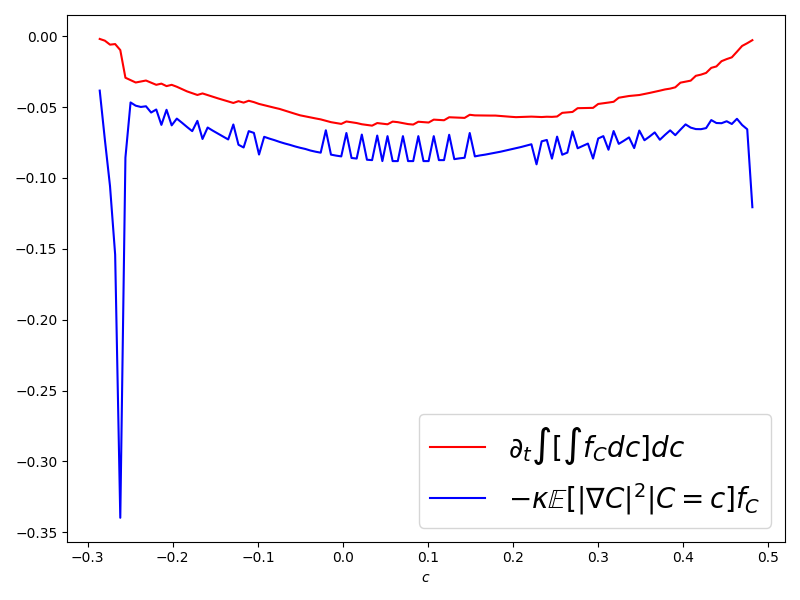

In [29]:
LHS =  L_inv@dfdt;
RHS = -kappa*E*f_C #- L_inv@D@S

# Plotting
fig = plt.figure(figsize=(8,6))

plt.plot(c,LHS,'r-',label=r'$\partial_t \int [\int f_C dc] dc$')
plt.plot(c,RHS,'b-',label=r'$-\kappa \mathbb{E}[ |\nabla C|^2 |C=c] f_C $')

plt.xlabel(r'$c$')
#plt.xlim([min(s),max(s)])
plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig('Equation_terms_HIST.png',dpi=200)
plt.show()

Plotting these terms above we see that the left and right hand sides balance thus numerically validating our equation for this example. Below we also plot the PDF conditional expectation and the scalar conecentration $C(z;t=1)$.

INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


2024-01-15 17:49:03,298 matplotlib.mathtext 0/1 INFO :: Substituting symbol E from STIXNonUnicode


INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


2024-01-15 17:49:03,535 matplotlib.mathtext 0/1 INFO :: Substituting symbol E from STIXNonUnicode


INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


2024-01-15 17:49:04,132 matplotlib.mathtext 0/1 INFO :: Substituting symbol E from STIXNonUnicode


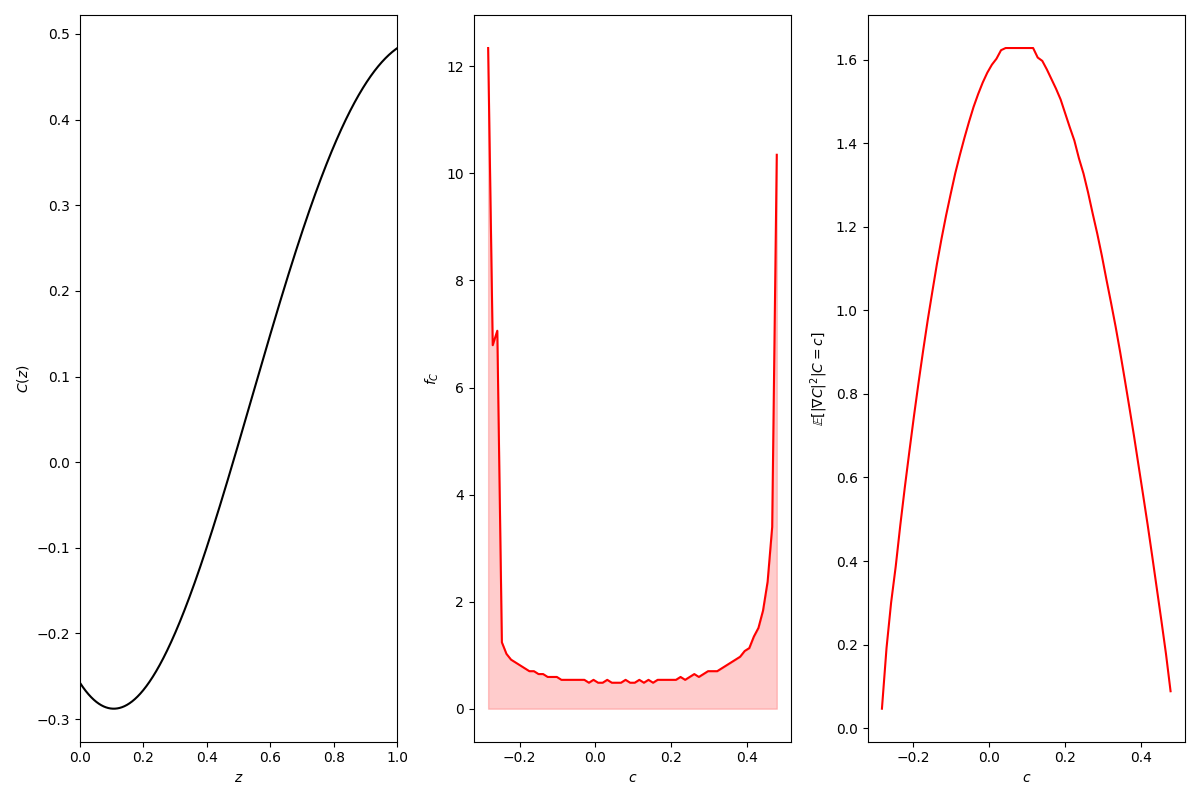

In [37]:
fig, axs = plt.subplots(1,3,figsize=(12,8))

axs[0].plot(z_data,C_data[-1,:],'k')
axs[0].set_xlim([0,1])
axs[0].set_ylabel(r'$C(z)$')
axs[0].set_xlabel(r'$z$')

axs[1].plot(c,f_C,'r')
axs[1].fill_between(x=c,y1=f_C,color= "r",alpha= 0.2)
axs[1].set_ylabel(r'$f_C$')
axs[1].set_xlabel(r'$c$')

axs[2].plot(c,E,'r')
axs[2].set_ylabel(r'$\mathbb{E}[|\nabla C|^2 |C=c]$')
axs[2].set_xlabel(r'$c$')

plt.tight_layout()
plt.savefig('Field_And_PDF.png',dpi=200)
plt.show()